# Map DTM data on a GPS track

Pour transférer des infos du raster sur la trace

## Let's start by defining our environment

This task is only useful for the online notebook

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Let's load the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tracklib as tkl

## Load the GPS track 

The GPS track represents an extract route in Vercors

Text(901895.5667177888, 6435537.8661504565, 'E')

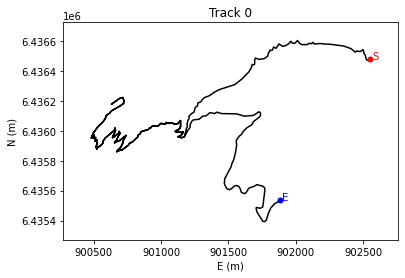

In [3]:
tkl.ObsTime.setReadFormat("4Y-2M-2D 2h:2m:2s")
resource_path = './'
filepath = os.path.join(resource_path, '../../../data/XYZBRAVOSANSFIDOUTEST.txt')
param = tkl.TrackFormat({'ext': 'CSV', 'id_E': 0, 'id_N': 1, 'id_U': 2, 'id_T': -1, 'header':1})
track = tkl.TrackReader.readFromFile(filepath, param)
track = track[400:900]

# Display the track
track.plot()

# Display start and end of route
plt.plot(track[0].position.getX(), track[0].position.getY(), 'ro', markersize=5)
plt.text(track[0].position.getX() + 15, track[0].position.getY() + 1.1, 'S', color="red")

plt.plot(track[499].position.getX(), track[499].position.getY(), 'bo', markersize=5)
plt.text(track[499].position.getX() + 15, track[499].position.getY() + 1.1, 'E', color="blue")

## Load the tile of DTM data

-------------------------------------
Raster:                              
-------------------------------------
       nrows = 303
       ncols = 320
       XPixelSize = 5
       YPixelSize = 5
       Extent: width = 1600.0, height = 1515.0
   Bounding box: 
       Lower left corner : 900372.5, 6435217.5
       Upper right corner: 901972.5, 6436732.5
-------------------------------------



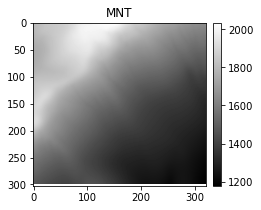

In [4]:
ascfilepath = os.path.join(resource_path, '../../../data/asc/mnt_XYZBRAVOSANSFIDOUTEST_2.asc')

raster = tkl.RasterReader.readFromAscFile(ascfilepath, 'MNT')
print (raster)
#raster.setNoDataValue(np.nan)
grid = raster.getAFMap(0)
print (grid)
grid.plotAsImage()

## Map on track and compare with the raw data

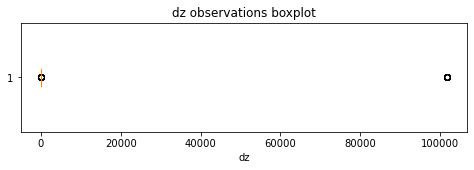

In [5]:
tkl.mapOnRaster(track, raster)

track.operate(tkl.Operator.SUBSTRACTER, "z", "MNT", "diff")
track.operate(tkl.Operator.RECTIFIER, "diff", "dz")

track.plotAnalyticalFeature('dz', 'BOXPLOT')

## Final result graphic

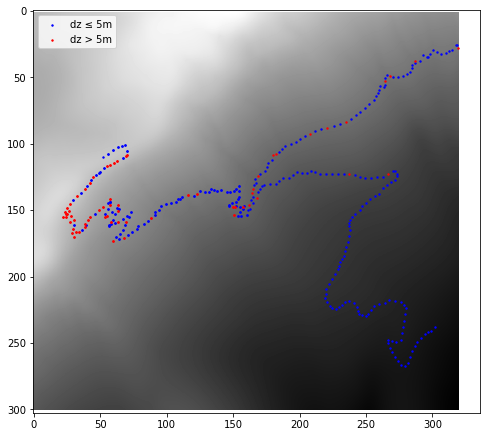

In [6]:
fig = plt.figure(figsize=(8, 8))

# Draw raster
tab = np.array(grid.grid, dtype=np.float32)
if raster.getNoDataValue() != None:
    tab[tab == raster.getNoDataValue()] = np.nan
plt.imshow(tab, cmap='gist_gray') # gist_gray


X1 = []
X2 = []
Y1 = []
Y2 = []
for i in range(track.size()):
    if raster.isIn(track[i].position):
        idx = (float(track[i].position.getX()) - raster.xmin) / raster.resolution[0]
        idy = (raster.nrow-1) - (float(track[i].position.getY()) - raster.ymin) / raster.resolution[1]
        if track.getObsAnalyticalFeature('dz', i) > 5:
            X2.append(idx)
            Y2.append(idy)
        else:
            X1.append(idx)
            Y1.append(idy)
plt.scatter(X1, Y1, c='blue', s=2, label='dz ≤ 5m')
plt.scatter(X2, Y2, c='red', s=2, label='dz > 5m')
plt.legend()